In [12]:
%matplotlib notebook

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import abc
import networkx as nx
import scipy.stats as stats
import matplotlib.animation as animation
import matplotlib

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(linewidth=200, suppress=True)

# Differential Equation Solver

### Various solvers available (Default: Runge-Kutta)

In [14]:
class DynamicsSolver():

    def __init__(self, fx, x0, t0=0.0, delta_t=0.001, nsteps=10000, solver=None, 
                 sstep=100, threshold=1e-12, apply_threshold=False):
        self.fx = fx
        self.x0 = x0
        self.t0 = t0
        self.delta_t = delta_t
        self.nsteps = nsteps
        self.sstep = sstep
        self.threshold = threshold
        self.apply_threshold = apply_threshold

        self.methods = {self.euler: "Euler's method", self.improved_euler: "Improved Euler's method",
                        self.runge_kutta: "Runge-Kutta method"}
        
        if not solver:
            self.solver = self.runge_kutta

    def euler(self, xi):
        delta_x = self.fx(xi) * self.delta_t
        return delta_x

    def improved_euler(self, xi):
        xi_plus_one = xi + self.fx(xi) * self.delta_t
        delta_x = 0.5 * (self.fx(xi) + self.fx(xi_plus_one)) * self.delta_t
        return delta_x

    def runge_kutta(self, xi):
        k1 = self.fx(xi) * self.delta_t
        k2 = self.fx(xi + 0.5 * k1) * self.delta_t
        k3 = self.fx(xi + 0.5 * k2) * self.delta_t
        k4 = self.fx(xi + k3) * self.delta_t
        delta_x = (1.0 / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        return delta_x

    def solve(self):
        x = []
        xi = np.copy(self.x0)
        for i in range(self.nsteps):
            if i % self.sstep == 0: # keep that value
                x.append(np.copy(xi))
            delta_x = self.solver(xi)
            xi += delta_x

            # if threshold
            if self.apply_threshold:
                if sum(np.fabs(delta_x)) < self.threshold:
                    break

        return np.array(x)

    def xt(self, x, t):
        index = int((t - self.t0) / (self.delta_t * self.sstep))
        return x[index]

    def t(self):
        return [self.t0 + i * (self.sstep * self.delta_t) for i in range(int(self.nsteps / self.sstep))]

### Plot a time series

In [15]:
def plot_time_series(title, x, t, labels=None, x_min=0, x_max=5, t_min=0, t_max=10):
    # axes
    plt.plot([t_min, t_max], [0, 0], lw=1, color="black")
    plt.plot([0, 0], [x_min, x_max], lw=1, color="black")
    plt.grid()

    handles = plt.plot(t, x)
    plt.xlim([t_min, t_max])
    plt.ylim([x_min, x_max])
    plt.title("Time series: " + title)
    plt.xlabel("t")
    plt.ylabel("x(t)")
    if labels:
        plt.legend(handles, labels)

# Basic Abstract Class for Dynamical Systems

In [16]:
class DynamicalSystem:

    __metaclass__ = abc.ABCMeta

    @abc.abstractmethod
    def fx(self, x):  # a system needs to implement differential equations in this function
        return

# Dynamics on Networks

### Few helper functions

In [17]:
# figure counter
def fcounter():
    i = 1
    while True:
        yield i
        i += 1

fc = fcounter()

# graph laplacian
def graph_laplacian(A):
    k = np.sum(A, axis=0)
    L = np.diag(k) - A
    return L

class AnimateNDynamics:

    def __init__(self, G, x, t, nc):
        self.radius = 0.04
        self.nc = nc

        fig = plt.figure(next(fc))
        ax = plt.axes(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
        colors = matplotlib.rcParams['axes.color_cycle']
        self.time_text = ax.text(1.1, 1.1, "", ha="right")

        pos = nx.spring_layout(G)
        nx.draw_networkx_edges(G, pos)
        i = 0
        self.circles = []
        for node, position in pos.items():
            circle = plt.Circle((position[0], position[1]), radius=self.radius,
                                ec="black", fc=colors[i % len(colors)], label="%d"%i)
            self.circles.append(circle)
            ax.add_patch(circle)
            plt.text(position[0], position[1], "$%d$"%node, verticalalignment="center",
                     horizontalalignment="center", color="black", fontsize=12)
            i += 1
        self.x = x
        self.t = t

        self.ani = animation.FuncAnimation(fig, self.animate, frames=len(t), interval=300,
                                           blit=False, init_func=self.init_anim, repeat=False)

    def init_anim(self):
        self.resize(0)
        self.time_text.set_text("t=0ms")
        return self.circles, self.time_text

    def animate(self, i):
        self.resize(i)
        self.time_text.set_text("t=%dms"%((self.t[1] - self.t[0]) * 1000 * i))
        return self.circles, self.time_text

    def normalize(self, i):
        return [y / self.nc for y in self.x[i]]

    def resize(self, i):
        r = self.normalize(i)
        j = 0
        for circle in self.circles:
            circle.set_radius(r[j] * self.radius)
            j += 1

# Diffusion

In [18]:
class Diffusion(DynamicalSystem):

    def __init__(self, C, A):
        self.C = C
        self.L = graph_laplacian(A)

    def fx(self, x):
        return -self.C * np.dot(self.L, x)

<IPython.core.display.Javascript object>


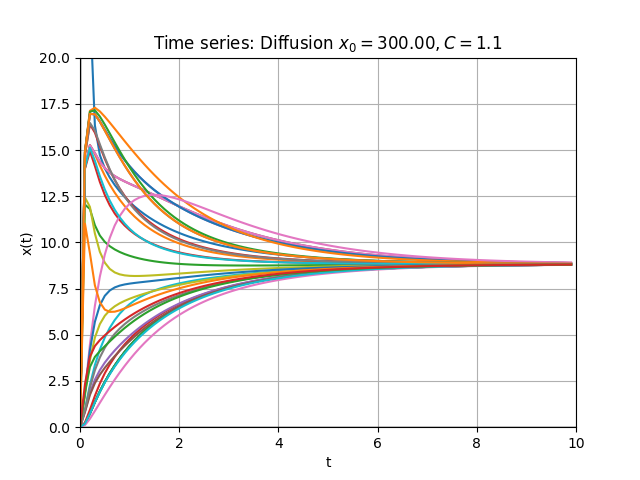

In [30]:
G = nx.karate_club_graph()
A = nx.adjacency_matrix(G).todense().A
n, n = A.shape

# diffusion on the karate network
C = 1.1
diffusion = Diffusion(C, A)
x0 = np.array([300.0] + [0.0] * (n - 1))

# solver
solver = DynamicsSolver(diffusion.fx, x0)
x = solver.solve()
t = solver.t()

plt.figure(next(fc))
plot_time_series('Diffusion $x_0=%3.2f, C=%2.1f$' % (sum(x0), C), x, t, x_max=20)
plt.draw()

<IPython.core.display.Javascript object>


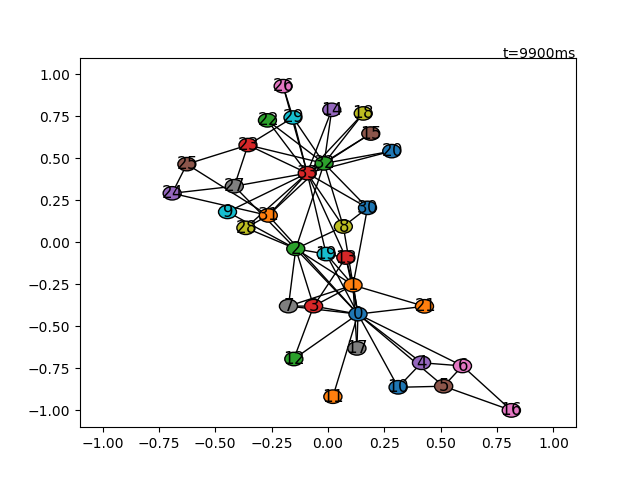

In [31]:
ani = AnimateNDynamics(G, x, t, 300.0 / 34)
plt.draw()

# Population Growth

In [21]:
class PopGrowth(DynamicalSystem):

    def __init__(self, a, r, A):
        self.a = a
        self.r = r
        self.L = graph_laplacian(A)

    def fx(self, x):
        n, n = self.L.shape
        return self.r * x * (np.ones(n) - x) + self.a * np.dot(self.L, x * x)

<IPython.core.display.Javascript object>


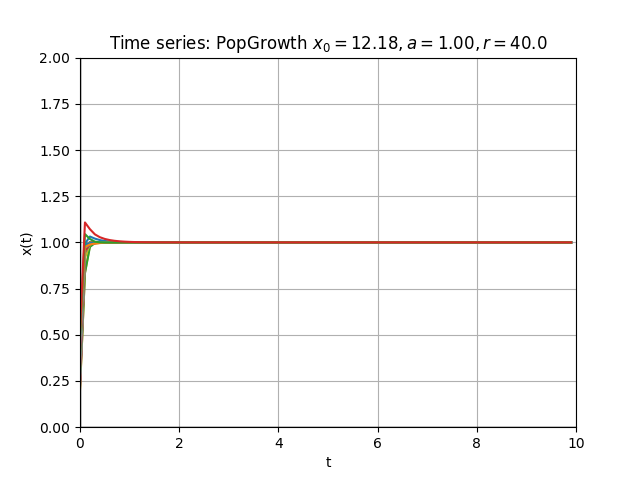

In [36]:
# population growth on the karate network lambda_n = 18.13666
a = 1.0
r = 40.0 # use r = 30.0 for the other behavior

pop = PopGrowth(a, r, A)
x0 = np.array([0.3] + [0.2 + 0.01 * i for i in range(n - 1)])

# solver
solver = DynamicsSolver(pop.fx, x0)
x = solver.solve()
t = solver.t()

plt.figure(next(fc))
plot_time_series("PopGrowth $x_0=%3.2f, a=%3.2f, r=%2.1f$"%(sum(x0), a, r), x, t, x_max=2.0)
plt.draw()

<IPython.core.display.Javascript object>


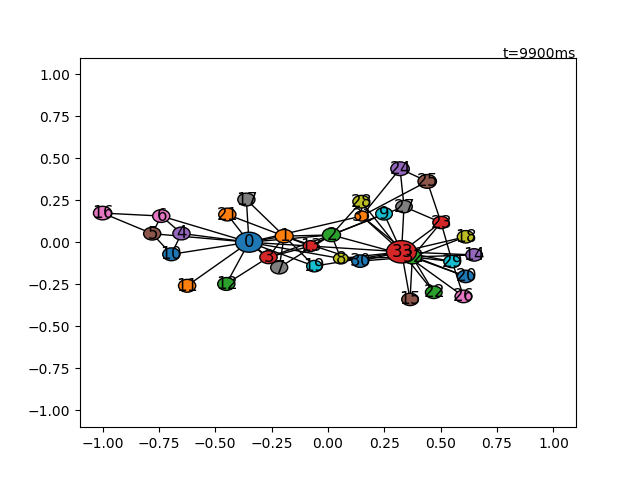

In [35]:
ani = AnimateNDynamics(G, x, t, 1.0)
plt.draw()

# Gossip Example

In [24]:
class Gossip(DynamicalSystem):

    def __init__(self, a, b, A):
        self.a = a
        self.b = b
        self.L = graph_laplacian(A)

    def fx(self, x):
        n, n = self.L.shape
        gx = [y / (1 + y) for y in x]
        return self.a * (np.ones(n) - x) + self.b * np.dot(self.L, gx)

<IPython.core.display.Javascript object>


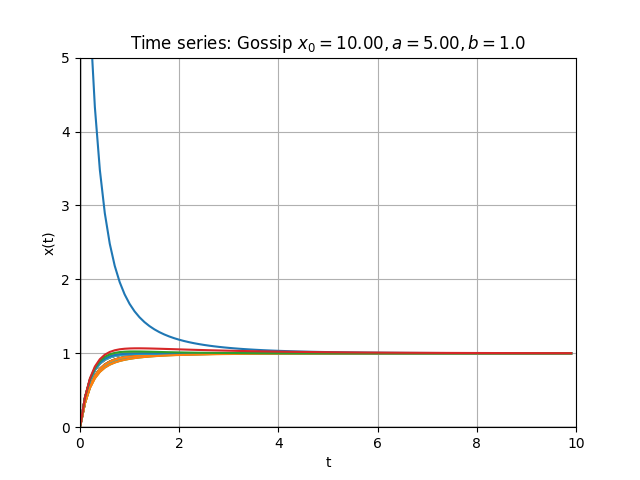

In [41]:
# gossip on the karate network lambda_n = 18.13666
a = 5.0
b = 1.0 # b = 1.4

gossip = Gossip(a, b, A)
x0 = np.array([10.0] + [0.0] * (n - 1))

# solver
solver = DynamicsSolver(gossip.fx, x0)
x = solver.solve()
t = solver.t()

plt.figure(next(fc))
plot_time_series("Gossip $x_0=%3.2f, a=%3.2f, b=%2.1f$"%(sum(x0), a, b), x, t, x_max=5.0)
plt.draw()

<IPython.core.display.Javascript object>


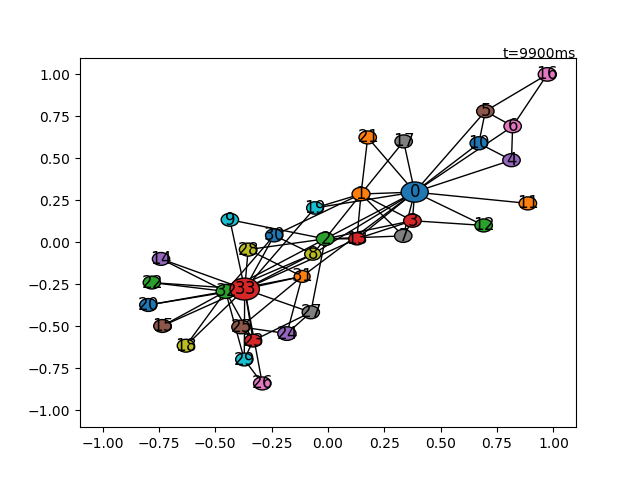

In [40]:
ani = AnimateNDynamics(G, x, t, 1.0)
plt.draw()